# Photogrammetry  
  
***
## Goals  
  
- Calculate distance to the human actor using coordinates (x;y position of the human face in the frame) from two cameras placed in parallel.  
- Provide single space x;y;z coordinates for the object.  
  
***
## Description   
<img src='./images/1.png' alt='room top view' width='500'>  
  
Small room with a human actor inside. On one of the walls we have two cameras placed in parallel to each other:  
  
- Distance between the cameras: 1 meter (100.0)  
- Angle of view (AOV) for both cameras: 78° (degrees)  
- Frame width: 2048 px; Frame height: 1080 px.   
  
### Simplified example  
Two cameras (Blue and Green) are observing the Actor movements on the scene:  
<img src='./images/2.png' alt='room top view' width='750'>  
  
### Observable frames for “Actor position 1” (In-front of the camera #1):  
<img src='./images/3.png' alt='room top view' width='500'>  
  
Simplified coordinates (for illustrative purposes only):  
> #### Input:  
> Camera #1 coordinates: x:1024 y:540  
> Camera #2 coordinates: x:0 y:540  
> #### Output:  
> Estimate of Mid camera position: x:512 y:540 z: 250  
  
### “Actor position 2” (Between the cameras):  
<img src='./images/4.png' alt='room top view' width='500'>  
  
### “Actor position 3” (In-front of the camera #2):  
<img src='./images/5.png' alt='room top view' width='500'>  
  
***
## Delivery  
  
Python or C/C++ script which accepts X;Y coordinates for two cameras and returns the x;y;z single space coordinates (e.g. assuming the mid camera position).  
X - horizontal coordinate;  
Y - Vertical coordinate;  
Z - Depth / Distance to the object.

***  
# Solution
***

1. Unfortunately, I haven't got any experience working with photogrammetry tasks yet. Therefore, at first, I have to dive into the theory and gather some knowledge  
  
2. I also want to focus on the task and clear the plan of solving it.  
   After my small math investigation I will have to write a `python class` or a `function`, which will have:
   > **Its input:**  
   > - `tuple(int, int)` X, Y coordinate of the face center from Camera 1  
   > - `tuple(int, int)` X, Y coordinate of the face center from Camera 2  
   >
   > Also these args are hardcoded by the task:  
   > - `float` Distance between cameras  
   > - `float` Angle of view (AOV)  
   > - `(int, int)` Frame resolution  
  
   > **Output:**  
   > - `tuple(int, int, int)` of X, Y, Z coordinates of the object 

***  
## How to find the distance to an object using two cameras  
[Source article](https://www.sciencedirect.com/science/article/pii/S2590005620300011)
  
<img src='./images/3.jpg' alt='stereo camera schema' width='300'>  
  
Firstly I have to express somehow the height (`h`) of the triangle via known measurements in a few possible ways  
  
From $ sin\phi = \frac{h}{B} $, $ sin\theta = \frac{h}{C} $ we know that:  
  
$ h = B * sin\phi = C * sin\theta $  
  
From law of sines: $ \frac{A}{sin\alpha} = \frac{B}{sin\theta} $:
  
$ B = \frac{A sin\theta}{sin\alpha} $  
  
And finally we can represent `h` as: $ h = \frac{A sin\theta * sin\phi}{sin\alpha} $
  
<img src='./images/2.jpg' alt='stereo camera schema' width='700'>  
  
Now I have to find a representation for $ \phi, \theta $ and $ \alpha $  
  
At first, I can easily find the $ \beta $ angles via:  
  
$ \beta = \frac{180 - \omega}{2} $  
  
Then I have to find O angles, which are our last piece of the puzzle in getting $\phi$ and $\theta$ angles  
  
It can be done by multiplying $P_1$, $P_2$ by $AP_1$, $AP_2$, where:  
> $P_1$ - is the distance between the object center and the right frame border  
> $P_2$ - is the distance between the object center and the left frame border  
> $AP$ - is Angle per Pixel rate, which is the same for both cameras in our case annd equals $ AP = \frac{\omega}{H} $  
  
$ O_1 = P_1 * AP_1 $, and $ O_2 = P_2 * AP_2 $  
  
Now we can assemble $\phi$ and $\theta$ angles formulas:  
  
$ \phi = P_1 * \frac{\omega_1}{H_1} + \beta_1 $, and $ \theta = P_2 * \frac{\omega_2}{H_2} + \beta_2 $  
  
Here we are left with only unknown $\alpha$ angle, which can be defined as below:  
  
$ \alpha = 180 - (\phi + \omega) $  
  
All in all, we can represent `h` as:  
  
$$ h = \frac{Asin(P_2 * \frac{\omega_2}{H_2} + \beta_2) * sin(P_1 * \frac{\omega_1}{H_1} + \beta_1)}{sin(180 - P_1 * \frac{\omega_1}{H_1} + \beta_1 + \omega + P_2 * \frac{\omega_2}{H_2} + \beta_2)} $$

***
## The function code:

In [36]:
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt

In [134]:
def calculate_distance(coords1: Tuple[int, int], \
                       coords2: Tuple[int, int], \
                       dist_between_cams: int = 100, \
                       aov: float = 78, \
                       resolution: Tuple[int, int] = (2048, 1080), \
                       verbose: int = 0) -> int:
    """
    This function receives 2 tuples with coordinates of object center from 2 cameras
    And returns the distance to the object
    """    
    P1 = resolution[0] - coords1[0]
    P2 = coords2[0]
    
    AP = aov / resolution[0]
    beta = (180 - aov) / 2
    
    phi = P1 * AP + beta
    theta = P2 * AP + beta
    alpha = 180 - (phi + theta)
    
    z = (dist_between_cams * np.sin(np.radians(theta)) * np.sin(np.radians(phi))) / (np.sin(np.radians(alpha)))
    
    if verbose > 0:
        print(f'dist_between_cams: {dist_between_cams}, aov: {aov}, resolution: {resolution}\n'
              f'P1: {P1}, P2: {P2}, AP: {AP}, beta: {beta}\n'
              f'phi: {phi}, theta: {theta}, alpha: {alpha}\n'
              f'z: {z}')
    
    return round(z, 1)

In [137]:
# a test case
calculate_distance((2000, 540), (48, 540), verbose=1)

dist_between_cams: 100, aov: 78, resolution: (2048, 1080)
P1: 48, P2: 48, AP: 0.0380859375, beta: 51.0
phi: 52.828125, theta: 52.828125, alpha: 74.34375
z: 65.93975442623402


65.9

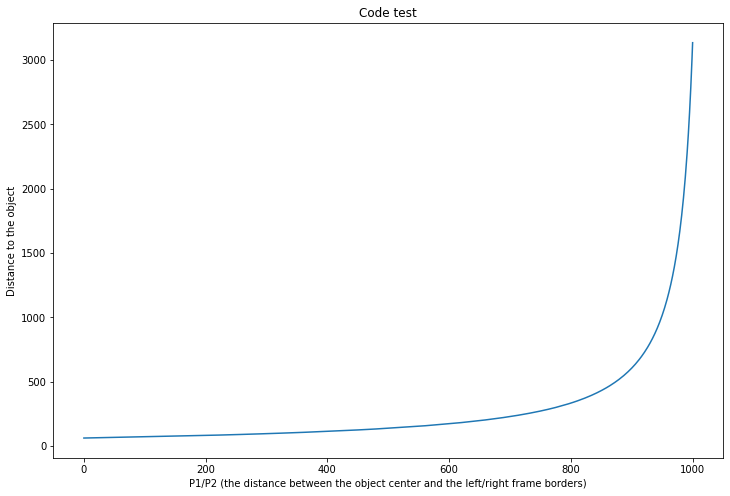

In [160]:
# a bigger test
grid = np.arange(0, 1000 + 1)
calc_dist_results = []

for i in grid:
    # the function gets such coordinates as we would slowly step straight backwards (away from cameras)
    calc_dist_results.append(calculate_distance((2048 - i, 540), (0 + i, 540)))

# the graphic have to looks like an exponent function
plt.figure(figsize=(12, 8))
plt.plot(grid, calc_dist_results)
plt.title('Code test')
plt.xlabel('P1/P2 (the distance between the object center and the left/right frame borders)')
plt.ylabel('Distance to the object')
plt.show()

***
## Some conclusions and problems:

Now my function returns the distance to the object by the given tuples of coordinates and it works correctly, BUT it returns us the value in centimeters  
**Therefore, we can't just type the `distance to the object` value as a third coordinate**  
  
I decided it would be right to come up with a new single space (with units measured in centimeters), which would represent an actors position on a scene  
So far we already have 2-dimensional space with the units in centimeters. Segments, which are representing the space are:  
- Distance between cameras  
- The found distance to the object/person  
  
These will be our X and Z axes  
I've decided, that the anchor point (a point in a 3-dimensional space with coordinates (0, 0, 0)) is in our mid camera  
>`X+` means that the actor is on the right relative to the mid cam  
>`Y+` means that the centroid of the face is higher than the mid cam  
>`Z+` means that the actor is in front of the mid cam  
  
### Further plan:   
Add two more functions, which will calculate X, Y coordinates in centimeter-united space  
  
**Additionally:**  
- I will code everything in OOP style  
- Add some exceptions  
- Specify functions arguments and outputs
- Write some comments
- Add a bit of debug strings

***
## More code:

In [151]:
class ActorPosition:

    def __init__(self, dist_between_cams: int = 100, aov: float = 78, resolution: Tuple[int, int] = (2048, 1080),
                 verbose: int = 0):
        self.dist_between_cams = dist_between_cams
        self.aov = aov
        self.resolution = resolution
        self.verbose = verbose

        if self.verbose > 0:
            print(f'ActorPosition.__init__(): dist_between_cams = {dist_between_cams}, aov = {aov}, '
                  f'resolution = {resolution}')

    def find_z(self, theta: float, phi: float, alpha: float) -> float:
        # height = (dist_between_cams * sin(theta) * sin(phi)) / sin(alpha)
        z = (self.dist_between_cams * np.sin(np.radians(theta)) * np.sin(np.radians(phi))) / np.sin(np.radians(alpha))

        if self.verbose > 0:
            print(f'ActorPosition.find_z(): z = {z:.1f}cm')

        return round(z, 1)

    def find_x(self, z: float, phi: float) -> float:
        B = z / np.sin(np.radians(phi))
        AD = np.sqrt((B ** 2) - (z ** 2))
        x = AD - 50

        if self.verbose > 0:
            print(f'ActorPosition.find_x(): x = {x:.1f}cm,\nB = {B:.1f}cm, AD = {AD:.1f}cm')

        return round(x, 1)

    def find_y(self, z: float, y_coord: int) -> float:
        vertical_aov = (self.aov * self.resolution[1]) / self.resolution[0]
        vertical_AP = vertical_aov / self.resolution[1]
        vertical_P = y_coord - (self.resolution[1] / 2)
        gamma = vertical_AP * vertical_P
        y = z * np.tan(np.radians(gamma))

        if self.verbose > 0:
            print(f'ActorPosition.find_y(): y = {y:.1f}cm,\nvertical_aov = {vertical_aov:.3f}, vertical_AP = {vertical_AP:.3f}, '
                  f'vertical_P = {vertical_P}, gamma = {gamma}')

        return round(y, 1)

    def calculate_position(self, coords1: Tuple[int, int], coords2: Tuple[int, int]) -> Tuple[float, float, float]:
        """
        The function receives 2 tuples with coordinates of an object centroid from 2 cameras
        And returns the object position (in measurements system in which lies dist_between_cams argument)
        The anchor point of returned coordinates is located into the center camera
        """
        try:
            # Checking for correspondence between cameras resolution and given coordinates
            if coords1[0] <= self.resolution[0] and coords2[0] <= self.resolution[0] and \
               coords1[1] <= self.resolution[1] and coords2[1] <= self.resolution[1]:

                # The distance in pixel between the centroid of the object and the end of the overlap area
                # for the camera on the left (P1) | right (P2)
                P1 = self.resolution[0] - coords1[0]
                P2 = coords2[0]

                # AP - Angle per Pixel
                AP = self.aov / self.resolution[0]
                # beta - is the angle between camera aov border and 'distance_between_cams' line
                beta = (180 - self.aov) / 2

                # theta/phi are the angles at the base of the triangle
                theta = P2 * AP + beta
                phi = P1 * AP + beta
                # the last angle
                alpha = 180 - (phi + theta)

                if theta > 0 and phi > 0 and alpha > 0:
                    z = self.find_z(theta, phi, alpha)
                    x = self.find_x(z, phi)
                    y = self.find_y(z, coords1[1])

                    if self.verbose > 0:
                        print(
                            f'ActorPosition.calculate_position(): P1 = {P1}, P2 = {P2}, AP = {AP:.3f}, beta = {beta}, phi = {phi:.1f}, '
                            f'theta = {theta:.1f}, alpha = {alpha:.1f}\n')
                    print(f'Actor position: {(x, y, z)}')

                else:
                    print(f'ActorPosition.calculate_position(): WARNING! Provided coordinates are wrong {coords1}, '
                          f'{coords2}. Ensure that you pass real values')
                    return None

            else:
                print(f'ActorPosition.calculate_position(): WARNING! Provided coordinates don\'t fit cameras resolution\n'
                      f'You may need to specify "resolution" as a positional argument, when creating the class instance\n'
                      f'{coords1}, {coords2} not in {self.resolution}')
                return None

            return x, y, z

        except TypeError as e:
            print(f'ActorPosition.calculate_position(): ERROR! Some arguments most likely were provided as wrong type\n{e}')

In [152]:
# simple test case
actor_pos = ActorPosition(verbose=1)
actor_pos.calculate_position((2000, 540), (48, 540))

ActorPosition.__init__(): dist_between_cams = 100, aov = 78, resolution = (2048, 1080)
ActorPosition.find_z(): z = 65.9cm
ActorPosition.find_x(): x = -0.0cm,
B = 82.7cm, AD = 50.0cm
ActorPosition.find_y(): y = 0.0cm,
vertical_aov = 41.133, vertical_AP = 0.038, vertical_P = 0.0, gamma = 0.0
ActorPosition.calculate_position(): P1 = 48, P2 = 48, AP = 0.038, beta = 51.0, phi = 52.8, theta = 52.8, alpha = 74.3

Actor position: (-0.0, 0.0, 65.9)


(-0.0, 0.0, 65.9)

In [153]:
# actor in a random position
actor_pos = ActorPosition(verbose=0)
actor_pos.calculate_position((1500, 740), (48, 740))

Actor position: (-19.8, 12.3, 92.1)


(-19.8, 12.3, 92.1)

**Meaning of the coords above:**  
The actor is approximately 20 cm to the left of the middle camera, his face is 12 cm higher than the mid camera and he is approximately 1 meter away from the mid camera  
***  
**Warnings and 
exceptions tests:**

In [154]:
# Warning 1. Given coords bigger than have to be
actor_pos = ActorPosition(verbose=0)
actor_pos.calculate_position((3000, 740), (48, 740))

ActorPosition.calculate_position(): WARNING! Provided coordinates don't fit cameras resolution
You may need to specify "resolution" as a positional argument, when creating the class instance
(3000, 740), (48, 740) not in (2048, 1080)


In [156]:
# Warning 2. Given coords results with zero/negative angles in the triangle
actor_pos = ActorPosition(verbose=0)
actor_pos.calculate_position((-3000, 740), (48, 740))

ActorPosition.calculate_position(): WARNING! Provided coordinates are wrong (-3000, 740), (48, 740). Ensure that you pass real values


In [158]:
# Error. Basic TypeError exception
actor_pos = ActorPosition(verbose=0)
actor_pos.calculate_position(None, (48, 740))

ActorPosition.calculate_position(): ERROR! Some arguments most likely were provided as wrong type
'NoneType' object is not subscriptable


***
**P.S. Here are some sketches I've done during the solution development. I just find them funny :)**
<img src='./images/8.png' alt='stereo camera schema' width='900'>  
<img src='./images/10.png' alt='stereo camera schema' width='900'>  
<img src='./images/9.png' alt='stereo camera schema' width='900'>  